In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from util import *
%matplotlib inline

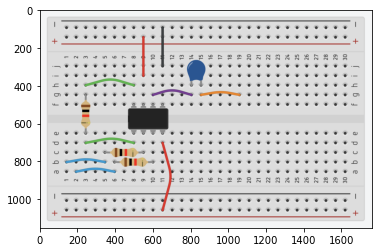

In [384]:
#img = cv2.imread('images/breadboard_plain.jpeg')
#img = cv2.imread('images/simple.jpg')
#img = cv2.imread('images/bb1.jpg')
img = cv2.imread('images/tinkercad.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display img
plt.imshow(img)
plt.show()


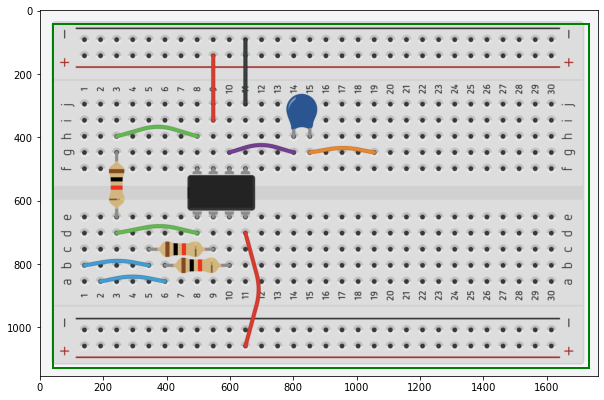

In [385]:
#input_boxes = [[67, 62, 590, 407]]
#input_boxes = [[79, 83, 1590, 1065]]
#input_boxes = [[30, 103, 468, 389]]
input_boxes = [[42, 44, 1735, 1128]]
show_boxes_on_image(img, input_boxes)

In [386]:
class Breadboard:
    # i might need to initialize the grid w.r.t with the breadboard coordinates, not image coordinates
    # because in the future, i might combine multiple images
    # connection should have a name
    
    def __init__(self, has_power_rails=True, grid=None):
        self.has_power_rails = has_power_rails
        self.num_rows = 10 # not including power rails
        self.num_cols = None # not including power rails
        self.grid = grid # middle of the breadboard (no power rails)

In [387]:
def identify_raw_keypoints(img, bounding_box):

    # identify blobs in the image and constrain them to the input boxes
    detector = cv2.SimpleBlobDetector_create()
    keypoints = detector.detect(img)

    # delete keypoints if they are not in the input boxes
    keypoints = [kp for kp in keypoints if kp.pt[0] > input_boxes[0][0] and kp.pt[0] < input_boxes[0][2] and kp.pt[1] > input_boxes[0][1] and kp.pt[1] < input_boxes[0][3]]

    # sort keypoints by y coordinate
    keypoints.sort(key=lambda x: x.pt[1])
    keypoints = [kp.pt for kp in keypoints]
    keypoints = np.array(keypoints, dtype=np.int32)

    # print the total number of keypoints
    print("Total number of keypoints: {}".format(len(keypoints)))

    return keypoints

Total number of keypoints: 376


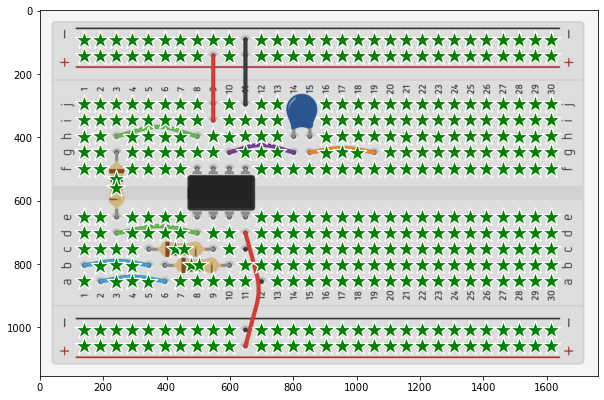

In [388]:
raw_keypoints = identify_raw_keypoints(img, input_boxes)
show_points_on_image(img, raw_keypoints)

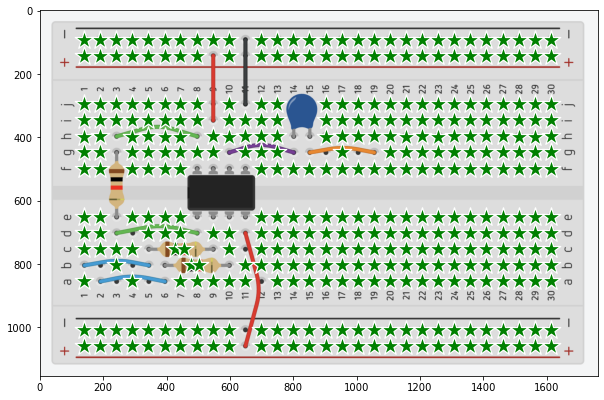

In [390]:
def divide(raw_keypoints):
    # separate into upper half and lower half
    num_clusters = 4
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(raw_keypoints)
    labels = kmeans.labels_
    # create sub-arrays within data to cluster according to the labels
    clusters = []
    for i in range(num_clusters):
        cluster = raw_keypoints[labels == i]
        clusters.append(cluster)
    # sort the clusters from left to right, top to bottom
    clusters.sort(key=lambda x: x[0][1])

    # merge cluster[0] and cluster[1] into one and cluster[2] and cluster[3] into one
    # because the two clusters are on the same row
    clusters[0] = np.concatenate((clusters[0], clusters[1]), axis=0)
    clusters[1] = np.concatenate((clusters[2], clusters[3]), axis=0)

    upper_half = clusters[0]
    lower_half = clusters[1]

    return upper_half, lower_half

upper_half, lower_half = divide(raw_keypoints)

def remove_outliers(upper_half, lower_half):
    # discard the x coordinates from the upper half if they appear only once OR if they appear once and on the edge
    def keep_condition(kp, half):
        x_unique, x_counts = np.unique(half[:, 0], return_counts=True)
        x_dict = dict(zip(x_unique, x_counts))
        if x_dict[kp[0]] > 1:
            return True # keep if there are more than one point with the same x coordinate
        else:
            if x_dict[kp[0]] == 1:
                if (kp != x_unique[0]).all() and (kp != x_unique[-1]).all():
                    return True
                else:
                    return False
            else:
                return False

    # discard the y coordinates from the upper half if they appear only once
    # make a dictionary where the key is the y coordinate and the value is the number of times it appears (from upper half)
    y_unique, y_counts = np.unique(upper_half[:, 1], return_counts=True)
    y_dict = dict(zip(y_unique, y_counts))
    upper_half = np.array([kp for kp in upper_half if y_dict[kp[1]] > 3])
    upper_half = np.array([kp for kp in upper_half if keep_condition(kp, upper_half)])

    y_unique, y_counts = np.unique(lower_half[:, 1], return_counts=True)
    y_dict = dict(zip(y_unique, y_counts))
    lower_half = np.array([kp for kp in lower_half if y_dict[kp[1]] > 3])
    lower_half = np.array([kp for kp in lower_half if keep_condition(kp, lower_half)])

    return upper_half, lower_half

def process_keypoints(raw_keypoints):
    upper_half, lower_half = divide(raw_keypoints)
    upper_half, lower_half = remove_outliers(upper_half, lower_half)
    # concatenate upper half and lower half
    clustered_keypoints = np.concatenate((upper_half, lower_half), axis=0)
    return clustered_keypoints

board_keypoints = process_keypoints(raw_keypoints)
show_points_on_image(img, board_keypoints)

At this point, you can expect that outliers are eliminated, but there are some gaps in the grid

In [391]:
def detect_power_rails(processed_keypoints):
    kps = processed_keypoints.tolist()
    kps.sort(key=lambda x: x[1])
    
    y_coords = [kp[1] for kp in kps]
    y_coords = np.unique(y_coords)

    y_rails = []
    y_counter = 0
    for rail_count in range(2):
        rail = []
        y_coord = y_coords[y_counter]
        rail.append(y_coord)
        neighbor = y_coords[y_counter + 1]
        if neighbor - y_coord < 3:
            rail.append(neighbor)
            y_counter += 2
        else:
            y_counter += 1
        y_rails.append(rail)

    y_counter = -1
    for rail_count in range(2):
        rail = []
        y_coord = y_coords[y_counter]
        rail.append(y_coord)
        neighbor = y_coords[y_counter - 1]
        if y_coord - neighbor < 3:
            rail.append(neighbor)
            y_counter -= 2
        else:
            y_counter -= 1
        y_rails.append(rail)

    # return an array of 4 elements, each of which contains (x, y) coordinates corresponding to the power rail
    rails = []
    for y_rail in y_rails:
        rail = []
        # rail will contain (x, y) coordinates corresponding to the power rail
        # takes all values corresponding to the y_rail key
        rail = [kp for kp in kps if kp[1] in y_rail]

        # sort rail by x coordinate
        rail.sort(key=lambda x: x[0])
        rails.append(rail)

    rail_keypoints = []
    for i in range(len(rails)):
        for j in range(len(rails[i])):
            rail_keypoints.append(rails[i][j])

    return rails
    
rails = detect_power_rails(board_keypoints)

In [392]:
def autofill_row(row, avg_distance):
    # example row: [[63, 372], [77, 372], [90, 372], [116, 372]]
    # as you can see, the x coordinates are not evenly spaced
    # there is a bigger gap between [90, 372] and [116, 372]
    # therefore, we need to fill in the missing point by putting it in the middle
    # sort the row by x coordinate
    y_mean = np.mean([kp[1] for kp in row])
    row = np.array(row)

    for i in range(len(row)):
        for j in range(i + 1, len(row)):
            distance = row[j][0] - row[i][0]
            #print(row[i], row[j], distance)
            # if the distance if significantly larger than the average distance, then we need to fill in the missing point
            margin = 0.15 * avg_distance
            if np.abs(distance - avg_distance) > margin:
                # how many points do we need to fill in?
                num_points = np.abs(distance - avg_distance) / avg_distance
                # round num_points to the nearest integer
                num_points = int(np.round(num_points))
                for _ in range(num_points):
                    x = (row[i][0] + row[j][0]) / 2
                    row = np.insert(row, j, [x, y_mean], axis=0)
                    j += 1
                    #print("inserted", x, y_mean)
            break
    return row

#row = [[63, 372], [77, 372], [90, 372], [116, 372]]
row = [[139, 92], [190, 92], [241, 92], [292, 92], [343, 92], [394, 92], [444, 92], [495, 92], [546, 92], [597, 92], [699, 92], [749, 92], [800, 92], [851, 92], [902, 92], [953, 92], [1004, 92], [1054, 92], [1105, 92], [1156, 92], [1207, 92], [1258, 92], [1309, 92], [1359, 92], [1410, 92], [1461, 92], [1512, 92], [1563, 92], [1614, 92]]
new_row = autofill_row(row, 13.32830829690874)

In [393]:

def autofill_rails(rails):
    autofilled_rails = []
    rails = np.array(rails)
    rail_keypoints = []
    for i in range(len(rails)):
        for j in range(len(rails[i])):
            rail_keypoints.append(rails[i][j])

    num_clusters = 10
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(rail_keypoints)
    labels = kmeans.labels_
    clusters = []
    for i in range(num_clusters):
        rail_keypoints = np.array(rail_keypoints)
        cluster = rail_keypoints[labels == i]
        clusters.append(cluster)

    # for clusters that have 10 points, compute the average distance between points
    distances = []
    for cluster in clusters:
        if len(cluster) == 10:
            for i in range(len(cluster)):
                for j in range(i + 1, len(cluster)):
                    distances.append(np.linalg.norm(cluster[i] - cluster[j])/2)
    avg_distance = np.mean(distances)
    

    # for clusters that are less than 10 points, fill in the missing points based on the average distance
    for i in range(len(clusters)):
        cluster = clusters[i]
        if len(cluster) < 10:
            kmeans = KMeans(n_clusters=2, random_state=0)
            kmeans.fit(cluster[:, 1].reshape(-1, 1))
            labels = kmeans.labels_
            rows = []
            for i in range(2):
                row = cluster[labels == i]
                if len(row) < 5:
                    row = autofill_row(row, avg_distance)
                rows.append(row)
            cluster = np.concatenate((rows[0], rows[1]), axis=0)
        autofilled_rails.append(cluster)

    rail_keypoints = []
    for i in range(len(autofilled_rails)):
        for j in range(len(autofilled_rails[i])):
            rail_keypoints.append(autofilled_rails[i][j])

    # sort rail_keypoints by y coordinate
    rail_keypoints.sort(key=lambda x: x[1])
    
    #show_points_on_image(img, rail_keypoints)
    return rail_keypoints

autofilled_rail_keypoints = autofill_rails(rails)

/var/folders/1r/3s253hw50_z29rw89v5v3n7m0000gn/T/ipykernel_1750/2206030413.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rails = np.array(rails)


In [394]:
def autofill_grid(grid_keypoints):
    autofilled_grid = []

    grid_keypoints = np.array(grid_keypoints)
    num_clusters = 10
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    # for clustering, use only the y coordinates
    kmeans.fit(grid_keypoints[:, 1].reshape(-1, 1))
    labels = kmeans.labels_
    rows = []
    for i in range(num_clusters):
        grid_keypoints = np.array(grid_keypoints)
        row = grid_keypoints[labels == i]
        rows.append(row)

    # sort each row by x coordinate
    for i in range(len(rows)):
        rows[i] = rows[i][rows[i][:, 0].argsort()]

    # for rows that have 30 points, compute the average distance between points
    distances = []
    for row in rows:
        if len(row) == 30:
            for i in range(len(row)):
                for j in range(i + 1, len(row)):
                    distance = row[j][0] - row[i][0]
                    distances.append(distance)
                    break
    avg_distance = np.mean(distances)
    
    # for rows that are less than 30 points, fill in the missing points based on the average distance
    new_rows = []
    for row in rows:
        if len(row) < 30:
            new_rows.append(autofill_row(row, avg_distance))
        else:
            new_rows.append(row)

    # add each element of new_rows to grid_keypoints

    for row in new_rows:
        for kp in row:
            autofilled_grid.append(kp)

    return autofilled_grid


/var/folders/1r/3s253hw50_z29rw89v5v3n7m0000gn/T/ipykernel_1750/2206030413.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rails = np.array(rails)
/Users/inga/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/inga/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


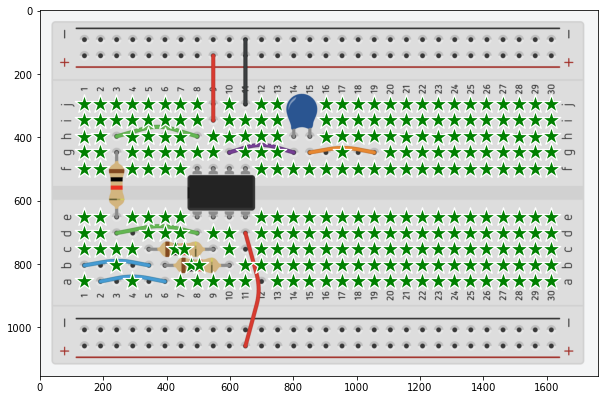

In [400]:
def process_board():
    board_keypoints = process_keypoints(raw_keypoints)
    rails = detect_power_rails(board_keypoints)
    autofilled_rail_keypoints = autofill_rails(rails)
    #show_points_on_image(img, autofilled_rail_keypoints)

    grid_keypoints = []
    for kp in board_keypoints:
        if not any((kp == rail).all() for rail in autofilled_rail_keypoints):
            grid_keypoints.append(kp)
    autofilled_grid_keypoints = autofill_grid(grid_keypoints)
    show_points_on_image(img, autofilled_grid_keypoints)

    return grid_keypoints, autofilled_rail_keypoints

grid_keypoints, rail_keypoints = process_board()